# SVM Modelling
SVM model for gesture classification.

In [1]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [2]:
dataset = pd.read_pickle('dataset.pkl')

Let's first reformat the dataset to a 2D array of shape (recordings x features).
Currently, the dataset is a 4D array of shape (recordings x windows x features x channels).

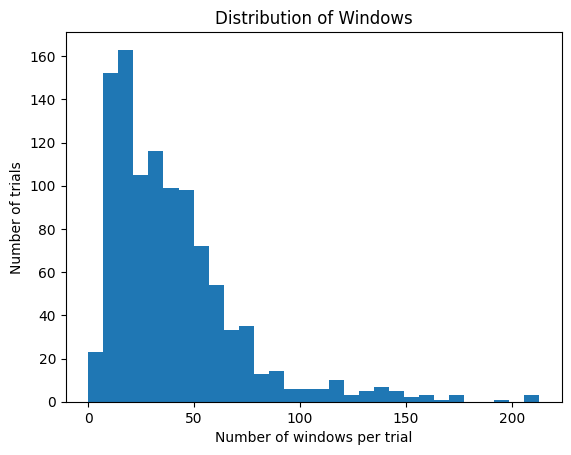

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

def reshape_data(data, y):
    """
    Converts data from:
    recordings x windows x features x channels
    to:
    recordings x windows x (features * channels)
    """

    # Convert X_train to list if it isn't already
    X_list = list(data)  # each element = recording with shape (windows, features, channels)
    y = list(y)

    X_clean = []
    y_clean = []

    for i, rec in enumerate(X_list):
        if np.array(rec).shape[0] > 0:   # keep only recordings with >0 windows
            X_clean.append(np.mean([w for w in rec], axis=0))  # mean across windows
            y_clean.append(y[i])  # keep corresponding label

    # Convert to arrays
    X_mean = np.array(X_clean)  # shape: (recordings_kept, features, channels)
    y_filtered = np.array(y_clean)

    # Optional: flatten for SVM
    X_svm = X_mean.reshape(X_mean.shape[0], -1)
    return X_svm, y_filtered

def plot_trials_histogram(data):
    # Convert pandas Series → list
    data_list = data.to_numpy()   # data is your Series

    # Count windows per trial
    window_counts = [len(trial) for trial in data_list]

    # Plot histogram
    plt.figure()
    plt.hist(window_counts, bins=30)
    plt.xlabel("Number of windows per trial")
    plt.ylabel("Number of trials")
    plt.title("Distribution of Windows")
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)
plot_trials_histogram(X_train)


To start, let's just classify pinch vs fist.

Test accuracy: 96.49%

Classification report:
              precision    recall  f1-score   support

        fist     0.9643    0.9643    0.9643        28
       pinch     0.9655    0.9655    0.9655        29

    accuracy                         0.9649        57
   macro avg     0.9649    0.9649    0.9649        57
weighted avg     0.9649    0.9649    0.9649        57



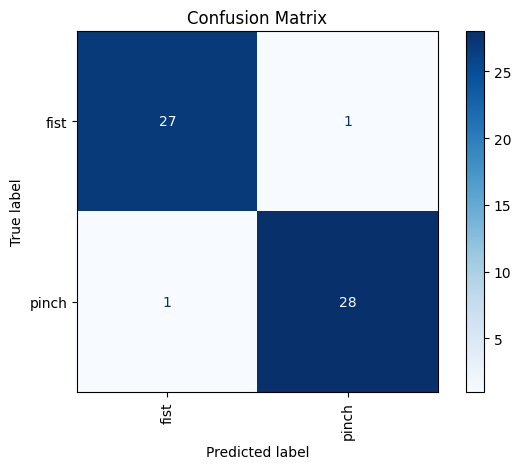

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

dataset = dataset[dataset['movement'].isin(['pinch', 'fist'])]

X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

X_train_svm, y_train = reshape_data(X_train, y_train)
X_test_svm, y_test = reshape_data(X_test, y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_train_scaled = scaler.transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

clf = LinearSVC(random_state=0, max_iter=10000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


Test accuracy: 89.23%

Classification report:
              precision    recall  f1-score   support

      3digit     0.7059    0.8276    0.7619        29
    cilinder     0.8605    0.9737    0.9136        38
        fist     0.8519    0.8846    0.8679        26
  index_flex     0.9032    0.9333    0.9180        30
 middle_flex     1.0000    0.8438    0.9153        32
       pinch     0.8750    0.8077    0.8400        26
       point     0.9310    0.9310    0.9310        29
    thumbExt     1.0000    1.0000    1.0000        29
   thumbFlex     1.0000    0.7619    0.8649        21

    accuracy                         0.8923       260
   macro avg     0.9031    0.8848    0.8903       260
weighted avg     0.9006    0.8923    0.8931       260



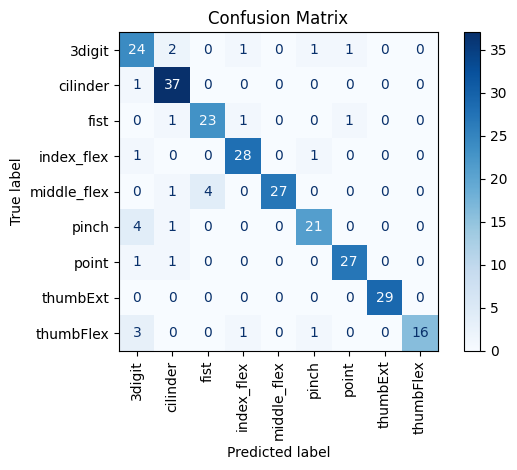

In [8]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

dataset = pd.read_pickle('dataset.pkl')

# set up X, y test / train split
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data(X_train, y_train)
X_test_svm, y_test = reshape_data(X_test, y_test)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_train_scaled = scaler.transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

# clf = LinearSVC(C=1.0, class_weight="balanced", max_iter=20000, random_state=0)
clf = SVC(C=10.0, kernel="rbf", gamma="scale", class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

Note that in the above SVM model, we take the feature average across all windows of a single recording. This is not unheard of for time series, windowed, classification model training. But taking an average across windows has shown to decrease accuracy of classifiers (https://arxiv.org/pdf/2002.00461).
Instead, let's try classifying each window independently.

In [9]:
def reshape_data_windows(data, y):
    """
    Converts data from:
    recordings x windows x features x channels
    to:
    total_windows x (features * channels)

    Labels are duplicated per window.
    """

    X_list = list(data)
    y = list(y)

    X_windows = []
    y_windows = []

    for rec_idx, rec in enumerate(X_list):
        rec = np.array(rec)

        # Skip recordings with no windows
        if rec.shape[0] == 0:
            continue

        for window in rec:
            # window shape: (features, channels)
            X_windows.append(window.reshape(-1))  # flatten to 938
            y_windows.append(y[rec_idx])           # same label per window

    X_out = np.array(X_windows)   # shape: (total_windows, 938)
    y_out = np.array(y_windows)   # shape: (total_windows,)

    return X_out, y_out

Test accuracy: 51.89%

Classification report:
              precision    recall  f1-score   support

      3digit     0.2778    0.3504    0.3099       685
    cilinder     0.6014    0.6939    0.6443      1787
        fist     0.4387    0.5860    0.5018       855
  index_flex     0.5016    0.4184    0.4562       772
 middle_flex     0.4573    0.3837    0.4173       907
       pinch     0.3439    0.4043    0.3716       700
       point     0.6905    0.5291    0.5991       894
    thumbExt     0.6823    0.6101    0.6442       595
   thumbFlex     0.6363    0.4922    0.5550      1404

    accuracy                         0.5189      8599
   macro avg     0.5144    0.4964    0.4999      8599
weighted avg     0.5349    0.5189    0.5212      8599



/Users/aidankirwin/Code/Gesture-Recognition/venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


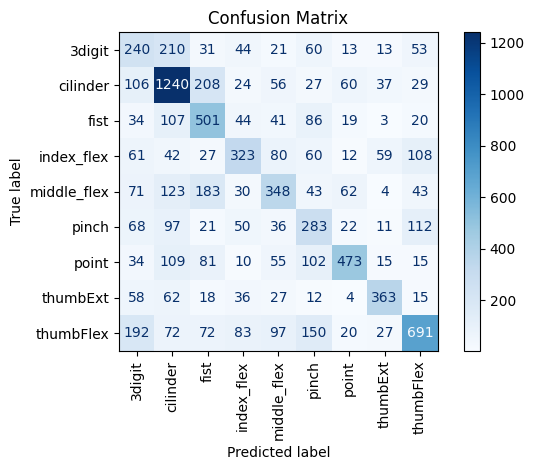

In [21]:
from sklearn.linear_model import SGDClassifier

# set up X, y test / train split
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# do a repeat test / train split to get validation data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data_windows(X_train, y_train)
X_test_svm, y_test = reshape_data_windows(X_test, y_test)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

# this uses stochastic gradient descent to solve loss function and fit a linear SVM
# should be faster than LinearSVC 
clf = SGDClassifier(
    loss="hinge",        # linear SVM
    class_weight="balanced",
    max_iter=1000,
    tol=1e-3,
    random_state=0,
)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

This did not converge and accuracy is low. Let's try again with an RBF classifier

Test accuracy: 70.28%

Classification report:
              precision    recall  f1-score   support

      3digit     0.4338    0.4978    0.4636       685
    cilinder     0.7510    0.8388    0.7925      1787
        fist     0.7037    0.6889    0.6962       855
  index_flex     0.6005    0.6580    0.6279       772
 middle_flex     0.6615    0.6141    0.6369       907
       pinch     0.6158    0.5886    0.6019       700
       point     0.8706    0.6622    0.7522       894
    thumbExt     0.8556    0.7765    0.8141       595
   thumbFlex     0.7719    0.7714    0.7716      1404

    accuracy                         0.7028      8599
   macro avg     0.6960    0.6774    0.6841      8599
weighted avg     0.7102    0.7028    0.7039      8599



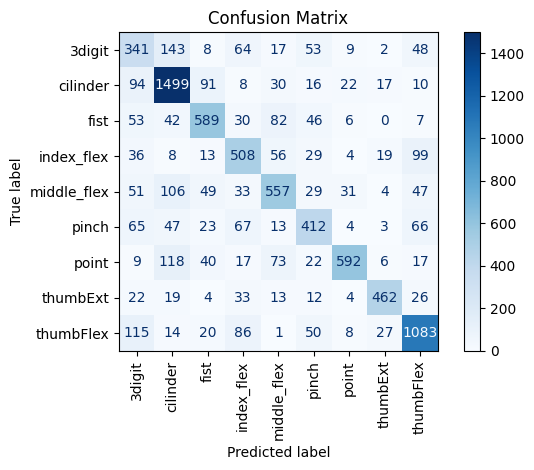

In [22]:
# set up X, y test / train split
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# do a repeat test / train split to get validation data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data_windows(X_train, y_train)
X_test_svm, y_test = reshape_data_windows(X_test, y_test)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

clf = SVC(C=10.0, kernel="rbf", gamma="scale", class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

Let's apply cross validation and perform a hyperparameter optimization for C and gamma.
We currently have 938 features, were going to use this for both SVM (gesture classification) and linear regression (joint angle prediction).
Due to the time it takes to train a model, we're going to dimension reduce this down.

To determine how many PCs to use, we'll check explained variance.

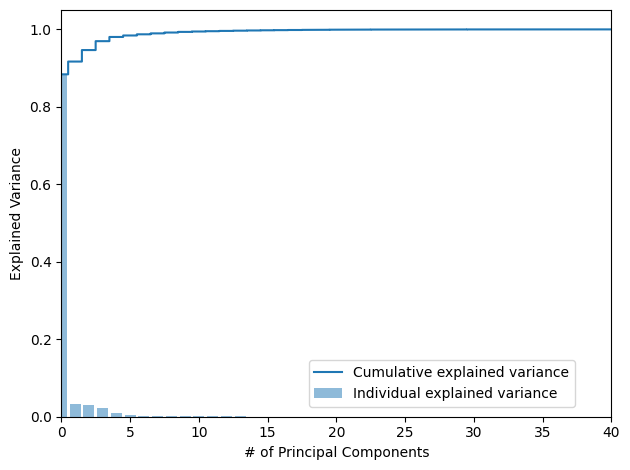

In [18]:
import sklearn.metrics
from sklearn.decomposition import PCA

dataset = pd.read_pickle('dataset.pkl')
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)
X_train_svm, y_train = reshape_data_windows(X_train, y_train)

pca = PCA().fit(X_train_svm)

# Data for plotting
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization
fig, ax = plt.subplots(1, 1)
ax.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
ax.set_xlim([0, 40])
ax.set_xlabel('# of Principal Components')
ax.set_ylabel('Explained Variance')
ax.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', label='Cumulative explained variance')
ax.legend(loc=(0.45, 0.025))
plt.tight_layout()
plt.show()

We can likely achieve similar accuracy with the first 40 PCs rather than all 938 features.

(33131, 100)
Test accuracy: 65.53%

Classification report:
              precision    recall  f1-score   support

      3digit     0.4889    0.5810    0.5310       685
    cilinder     0.7539    0.7387    0.7462      1787
        fist     0.5998    0.6082    0.6039       855
  index_flex     0.5914    0.5531    0.5716       772
 middle_flex     0.6774    0.5810    0.6255       907
       pinch     0.5045    0.5571    0.5295       700
       point     0.7965    0.5559    0.6548       894
    thumbExt     0.7878    0.7361    0.7611       595
   thumbFlex     0.6523    0.7963    0.7171      1404

    accuracy                         0.6553      8599
   macro avg     0.6503    0.6342    0.6379      8599
weighted avg     0.6647    0.6553    0.6557      8599



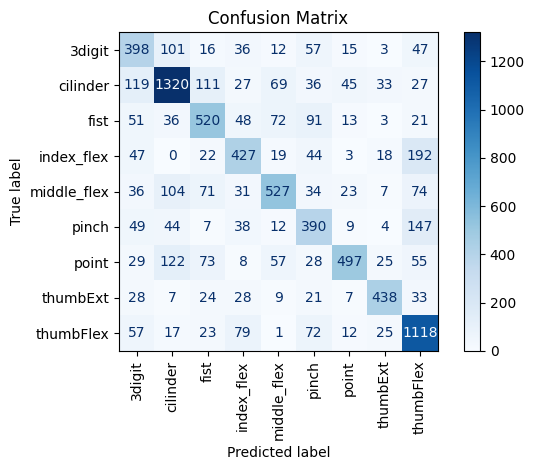

In [24]:
# set up X, y test / train split
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)
# do a repeat test / train split to get validation data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data_windows(X_train, y_train)
X_test_svm, y_test   = reshape_data_windows(X_test, y_test)

pca = PCA()
X_train_svm = pca.fit_transform(X_train_svm)[:, :100]
X_test_svm  = pca.transform(X_test_svm)[:, :100]

print(X_train_svm.shape)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

clf = SVC(C=10.0, kernel="rbf", gamma="scale", class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

C_j: 0.006737946999085467      (0 / 10)
0 of 4 cross validations
Validation accuracy: 0.19880182123172777
Training accuracy: 0.2026359932901989
1 of 4 cross validations
Validation accuracy: 0.1859573448358495
Training accuracy: 0.1925712916367122
2 of 4 cross validations
Validation accuracy: 0.1942966690630242
Training accuracy: 0.19496764917325665
3 of 4 cross validations
Validation accuracy: 0.2922597651569614
Training accuracy: 0.2982985861490534
C_j: 0.020468075714350484      (1 / 10)
0 of 4 cross validations
Validation accuracy: 0.4039779535106638
Training accuracy: 0.4020608674814282
1 of 4 cross validations
Validation accuracy: 0.3931943445962138
Training accuracy: 0.40115025161754136
2 of 4 cross validations
Validation accuracy: 0.40052719865803976
Training accuracy: 0.402588066139468
3 of 4 cross validations
Validation accuracy: 0.396117900790798
Training accuracy: 0.40781212556913493
C_j: 0.06217652402211632      (2 / 10)
0 of 4 cross validations
Validation accuracy: 0.499113

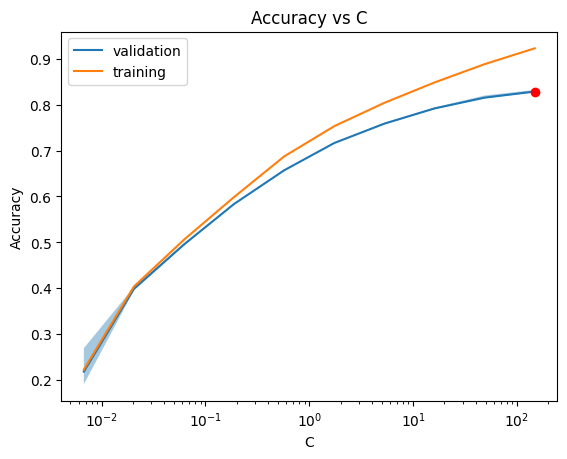

Optimal C parameter: 148.4131591025766


In [27]:
from scipy.stats import bootstrap

# set up X, y test / train split
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train, y_train = reshape_data_windows(X_train, y_train)

### Apply cross validation to optimize C. gamma is set to scale
# generate models
n = 10
acc_val_arr = []
acc_train_arr = []
ci_lows = [0] * n
ci_highs = [0] * n
Cs = np.exp(np.linspace(-5,5,n))
for j, c_j in enumerate(Cs):
    print(f'C_j: {c_j}      ({j} / {len(Cs)})')
    acc_val = []
    acc_train = []
    for i in range(4):
        print(f'{i} of 4 cross validations')
        # test train split
        X_train_i, X_validation_i, y_train_i, y_validation_i = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.5, shuffle=True, random_state=i)

        # perform pca
        pca = PCA()
        X_train_i       = pca.fit_transform(X_train_i)[:, :100]
        X_validation_i  = pca.transform(X_validation_i)[:, :100]

        # scaling
        scaler = StandardScaler()
        X_train_i       = scaler.fit_transform(X_train_i)
        X_validation_i  = scaler.transform(X_validation_i)

        # generate model
        reg = SVC(C=c_j, kernel="rbf", gamma='scale', class_weight="balanced")
        reg.fit(X_train_i, y_train_i)
        
        y_pred_val = reg.predict(X_validation_i)
        y_pred_train = reg.predict(X_train_i)

        acc_val.append(np.mean(y_pred_val == y_validation_i))
        acc_train.append(np.mean(y_pred_train == y_train_i))
        print(f'Validation accuracy: {acc_val[-1]}')
        print(f'Training accuracy: {acc_train[-1]}')

    acc_val_arr.append(np.mean(acc_val))
    acc_train_arr.append(np.mean(acc_train))
    ci_lows[j], ci_highs[j] = bootstrap([acc_val], np.mean).confidence_interval

# get best accuracy
max_acc_idx = np.argmax(acc_val_arr)
best_c = Cs[max_acc_idx]
best_acc = acc_val_arr[max_acc_idx]

# plot
plt.semilogx(Cs, acc_val_arr, label='validation')
plt.semilogx(Cs, acc_train_arr, label='training')
plt.plot(best_c, best_acc, 'ro')
plt.fill_between(Cs, ci_lows, ci_highs, alpha=0.4)
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs C')
plt.show()
print(f'Optimal C parameter: {best_c}')

C = best_c

In [31]:
import pprint

svm_output = {}
svm_output['Cs'] = Cs
svm_output['validation_accuracy'] = acc_val_arr
svm_output['training_accuracy'] = acc_train_arr
svm_output['ci_lows'] = ci_lows
svm_output['ci_highs'] = ci_highs
svm_output['best_C'] = best_c

with open('svm_output.pkl', 'wb') as file:
    pickle.dump(svm_output, file)

with open('svm_output.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

pprint.pprint(loaded_data, indent=4)

{   'Cs': array([6.73794700e-03, 2.04680757e-02, 6.21765240e-02, 1.88875603e-01,
       5.73753421e-01, 1.74290900e+00, 5.29449005e+00, 1.60832407e+01,
       4.88565713e+01, 1.48413159e+02]),
    'best_C': np.float64(148.4131591025766),
    'ci_highs': [   np.float64(0.268895279175653),
                    np.float64(0.4022525760843518),
                    np.float64(0.4976875149772346),
                    np.float64(0.5842199856218548),
                    np.float64(0.6584231967409538),
                    np.float64(0.7167265756050802),
                    np.float64(0.7605439731607956),
                    np.float64(0.7938533429187635),
                    np.float64(0.8199856218547807),
                    np.float64(0.832183081715792)],
    'ci_lows': [   np.float64(0.19012700694943685),
                   np.float64(0.39465612269350586),
                   np.float64(0.49276300023963576),
                   np.float64(0.5821710999281093),
                   np.float64(0.6559

Test accuracy: 68.91%

Classification report:
              precision    recall  f1-score   support

      3digit     0.5501    0.6459    0.5942      1155
    cilinder     0.8214    0.8106    0.8160      2836
        fist     0.5187    0.6353    0.5711       872
  index_flex     0.6543    0.6091    0.6309      1187
 middle_flex     0.7755    0.6066    0.6807      1464
       pinch     0.6828    0.6050    0.6416      1000
       point     0.7893    0.6537    0.7151      1129
    thumbExt     0.7474    0.8047    0.7750       717
   thumbFlex     0.5119    0.7000    0.5913       800

    accuracy                         0.6891     11160
   macro avg     0.6724    0.6745    0.6684     11160
weighted avg     0.7033    0.6891    0.6919     11160



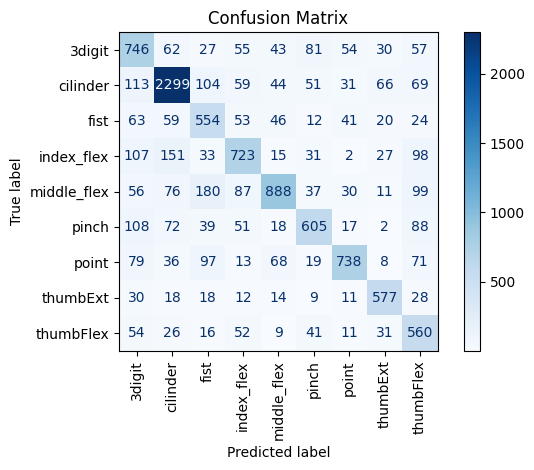

In [37]:
dataset = pd.read_pickle('dataset.pkl')

# get the test accuracy of the final model
# set up X, y test / train split
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train, y_train = reshape_data_windows(X_train, y_train)
X_test, y_test = reshape_data_windows(X_test, y_test)

# perform pca
pca = PCA()
X_train = pca.fit_transform(X_train)[:, :100]
X_test  = pca.transform(X_test)[:, :100]

# scaling
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

clf = SVC(C=148.4131591025766, kernel="rbf", gamma='scale', class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()